## Uniform Swarming Simulator

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of the idealized case of a perfectly simulation of bacterial swarming. This solves the ideal case where there is no spatial heterogeneity in the initial nutrient concentration in the system, allowing to avoid needing to resolve the individual branches areas tensor. Additionally, we also treat the system with periodic boundary conditions for simplicity and solve the nutrient PDE pseudospectrally.

We begin by importing all dependencies of interest. 

In [712]:
%reset -f
# Import numerical jax dependencies
import jax
from jax import numpy as jnp
from jax import vmap

# For readability. 
from collections import namedtuple

# Import plotting dependencies
import matplotlib.pyplot as plt
from jax_tqdm import scan_tqdm
from IPython.display import clear_output
import time


Next we will define the parameters of the PDE, including the spatial domain of the system simulation in both physical and wavenumber space. 

In [713]:
# Define geometry of simulation in time and space. 
L = 180 # Length of side of domain. 
totalT = 60 # Simulation time length
dt = 0.005 # Integration time step
nt = int(totalT/dt) # Number of time steps

# Define the number of nodes of the simualtion. 
nx = 384 # Number of grid points
ny = nx # Number of grid points
dx = L / nx # Grid spacing
dy = dx # Grid spacing

# Create a FD grid
x = jnp.arange(-L/2, L/2,dx)
y = jnp.arange(-L/2, L/2,dy)
XX, YY = jnp.meshgrid(x, y)
RR = jnp.sqrt(XX**2 + YY**2)

# Create an analogous fourier transform of the grid for use in solving the diffusion PDE. 
kx = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)
ky = 2*jnp.pi*jnp.fft.fftfreq(x.shape[0], dx)

KX, KY = jnp.meshgrid(kx, ky)
K = jnp.sqrt(KX**2 + KY**2)

#this function is used to convert the colony area into a potential field to guide colony branching and extension.
@jax.jit
def create_exponential_decay_kernel(decay_length):
    """
    Creates a 2D exponential decay kernel.

    Parameters:
        grid_size (int): Number of grid points in one dimension (assuming square grid).
        dx (float): Grid spacing in the x-direction.
        dy (float): Grid spacing in the y-direction.
        decay_length (float): Characteristic decay length for the potential.

    Returns:
        kernel (jnp.ndarray): 2D exponential decay kernel normalized to sum to 1.
    """
    # Create coordinate grids centered at zero
    x = jnp.fft.fftfreq(nx, d=dx) * nx * dx
    y = jnp.fft.fftfreq(ny, d=dy) * ny * dy
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    R = jnp.sqrt(X**2 + Y**2)

    # Define the exponential decay kernel
    kernel = jnp.exp(-R / decay_length)

    # Normalize the kernel to ensure the sum is 1
    kernel /= jnp.sum(kernel)

    return kernel



Now we fix the parameters associated to the pharmokinetics of the system. For a full description of the meaning of these model parameters, see the original Luo et. al paper from MSB. 

Now we define the first of our jax pure functions to handle updating the state of the system. This specific function will intake the current distribution of the nutrients in the system as well as the current distribution of cells and update the nutrient by numerically solving the reaction-diffusion PDE. 


LY note:
Added dealiasing to remove high-frequency components of the fourier transform of the nonlinear term (dN)

In [714]:
@jax.jit
def dealias(u_hat):
    nx, ny = u_hat.shape
    kx_cutoff = nx // 3
    ky_cutoff = ny // 3
    u_hat = u_hat.at[kx_cutoff:-kx_cutoff, :].set(0)
    u_hat = u_hat.at[:, ky_cutoff:-ky_cutoff].set(0)
    return u_hat

@jax.jit
def pde_update(pde_state, x, pde_params):
    N, C, P = pde_state
    bN, KN, aC, DN, Cm = pde_params

    # Compute reaction term
    fN = N * ((N + KN) ** (-1)) * Cm * ((C + Cm) ** (-1)) * C
#    fN = N * ((N + KN) ** (-1)) * Cm**3 * ((C**3 + Cm**3) ** (-1)) * C
    dN = -bN * fN

    # Fourier transform of N and dN
    N_hat = jnp.fft.fft2(N)
    dN_hat = jnp.fft.fft2(dN)

    # Apply dealiasing to dN_hat
    dN_hat = dealias(dN_hat)

    # Crank-Nicolson time-stepping
    pre_factor = (1 + 0.5 * DN * (K ** 2) * dt) ** (-1)
    post_factor = 1 - 0.5 * DN * (K ** 2) * dt
    N_new_hat = pre_factor * (post_factor * N_hat + dN_hat * dt)

    # Inverse Fourier transform to get N_new
    N_new = jnp.fft.ifft2(N_new_hat).real

    # Update C
    dC = aC * fN
    C_new = C + dC * dt

    return (N_new, C_new, P), None


Now we'll define a utility function in Jax to compute the PSD between the given set of coordinates. This will be used to assess the density of individual branches to determine bifurcation. 

In [715]:
def pairwise_distances(coordinates):   
    # Calculate squared distances between all pairs of coordinates
    squared_distances = jnp.sum((coordinates[:, None] - coordinates) ** 2, axis=-1)
    # Take the square root to get the actual distances
    distances = jnp.sqrt(squared_distances)
    return distances

In [716]:
@jax.jit
def compute_potential(colony_mask, decay_length):
    """
    Computes the potential field by convolving the colony mask with the exponential decay kernel.

    Parameters:
        colony_mask (jnp.ndarray): 2D array representing the colony (1 for cells, 0 elsewhere).
        kernel (jnp.ndarray): 2D exponential decay kernel.

    Returns:
        potential_field (jnp.ndarray): 2D potential field with high values at cell locations and decaying away.
    """
    kernel = create_exponential_decay_kernel(decay_length)

    # Compute the FFT of the colony mask and the kernel
    colony_hat = jnp.fft.fft2(colony_mask)
    kernel_hat = jnp.fft.fft2(kernel)

    # Perform element-wise multiplication in Fourier space (convolution)
    potential_hat = colony_hat * kernel_hat

    # Inverse FFT to get the potential field in spatial domain
    potential = jnp.fft.ifft2(potential_hat).real

    return potential


Now we will define the subroutines that will be used in updating the values of the system during the simulation. We have already defined the solver for the PDE step of the system, we will now consider subroutines for initializing and updating the branching tip agents throughout the course of the simulation. 


LY note:
Set the minimum to 3 branches as we almost never see 2-branch colonies

In [717]:
def init_pde(density, N0, c0, r0):
    """Initialize the PDE parameters for the system."""   
    N = jnp.zeros((nx, ny)) + N0
    P = (RR < r0).astype(jnp.int32)
    C = c0/( jnp.sum(P) * dx * dy)*(P)
    n_tips0 = jnp.maximum(jnp.ceil(2 * jnp.pi * r0 * density),3)  #we assume a minimum of 3 branches

    return (N, C, P), n_tips0

LY note:
Revised init_swarm to handle the case where num_init_branches is dynamically generated and to ensure vmap compatibility.

In [718]:
from jax import lax
import jax.numpy as jnp

@jax.jit
def init_swarm(num_init_branches):
    max_tips = 256
    # Preallocate swarm array and mask
    swarm_array = jnp.zeros((2 * max_tips + 2, 3))
    swarm_mask = jnp.zeros(2 * max_tips + 2)
    
    # Compute start layer and radial starting index using num_init_branches
    start_layer = jnp.ceil(jnp.log2(num_init_branches))
    start_index = jnp.power(2, start_layer).astype(jnp.int32)
    
    # Ensure start_index is within array bounds
    array_size = swarm_array.shape[0]
    max_init_branches = 60  # Set a fixed maximum number of initial branches
    start_index = jnp.minimum(start_index, array_size - max_init_branches)
    
    # Generate indices for the maximum number of initial branches
    indices = jnp.arange(max_init_branches)  # Shape: (max_init_branches,)
    
    # Create a mask for valid branches
    valid_mask = indices < num_init_branches  # Shape: (max_init_branches,)
    
    # Compute angles for the valid branches
    angle_step = 2 * jnp.pi / num_init_branches  # Scalar
    angles = indices * angle_step  # Shape: (max_init_branches,)
    angles = jnp.where(valid_mask, angles, 0.0)  # Zero out invalid angles
    
    # Compute x, y positions based on angles
    x_positions = 0.5 * jnp.cos(angles) * valid_mask
    y_positions = 0.5 * jnp.sin(angles) * valid_mask
    
    # Stack positions and angles
    updated_slice = jnp.stack([x_positions, y_positions, angles], axis=1)  # Shape: (max_init_branches, 3)
    
    # Dynamically update swarm_array and swarm_mask using start_index
    swarm_array = lax.dynamic_update_slice(swarm_array, updated_slice, (start_index, 0))
    swarm_mask = lax.dynamic_update_slice(
        swarm_mask, valid_mask.astype(jnp.float32), (start_index,)
    )
    
    return swarm_array, swarm_mask


In [719]:
@jax.jit
def bilinear_interpolate(x, y, xp, yp, zp):
    """Given a 2D scalar field N, estimate the value given x, y."""
    ix, iy = jnp.clip(jnp.searchsorted(xp, x, side="right"), 1, len(xp) - 1), jnp.clip(jnp.searchsorted(yp, y, side="right"), 1, len(yp) - 1)
    z_11, z_21, z_12, z_22 = zp[ix - 1, iy - 1], zp[ix, iy - 1], zp[ix - 1, iy], zp[ix, iy]
    dx, dy = xp[ix] - xp[ix - 1], yp[iy] - yp[iy - 1]
    z_xy1 = ((xp[ix] - x) * z_11 + (x - xp[ix - 1]) * z_21) / dx
    z_xy2 = ((xp[ix] - x) * z_12 + (x - xp[ix - 1]) * z_22) / dx
    z = ((yp[iy] - y) * z_xy1 + (y - yp[iy - 1]) * z_xy2) / dy

    return z

In [720]:
import jax
import jax.numpy as jnp

#LY note. Revised the method to be more momery efficient
@jax.jit
def return_candidates_matrix(x, y, theta, dl):
    """
    Generates candidate positions and angles for each active branch by exploring directions
    within a specified angular range around the current theta.

    Parameters:
    - x (jnp.ndarray): Current x positions of active branches. Shape: (N_active,)
    - y (jnp.ndarray): Current y positions of active branches. Shape: (N_active,)
    - theta (jnp.ndarray): Current directions (radians) of active branches. Shape: (N_active,)
    - dl (float): Length of expansion for branch growth.
    - delta_range (float): Maximum deviation from current theta (radians). Default is π/8 (~22.5°).
    - N_candidates (int): Number of candidate directions per branch. Default is 8.

    Returns:
    - x_candidates (jnp.ndarray): Candidate x-coordinates. Shape: (N_active, N_candidates)
    - y_candidates (jnp.ndarray): Candidate y-coordinates. Shape: (N_active, N_candidates)
    - theta_candidates (jnp.ndarray): Candidate angles relative to current theta. Shape: (N_active, N_candidates)
    """
    delta_range=jnp.pi/8
    N_candidates = 8
    # Generate relative angle offsets within [-delta_range, delta_range]
    relative_delta = jnp.linspace(-delta_range, delta_range, N_candidates)  # Shape: (N_candidates,)
    
    # Broadcast current theta to align with candidates
    theta_broadcasted = theta[:, None]  # Shape: (N_active, 1)
    
    # Compute absolute candidate angles
    delta = theta_broadcasted + relative_delta  # Shape: (N_active, N_candidates)
    
    # Compute candidate positions based on dl and theta_candidates
    x_candidates = x[:, None] + dl * jnp.cos(delta)  # Shape: (N_active, N_candidates)
    y_candidates = y[:, None] + dl * jnp.sin(delta)  # Shape: (N_active, N_candidates)
    
    return x_candidates, y_candidates, delta


In [721]:
import jax.numpy as jnp
from jax import vmap, jit

# Assume bilinear_interpolate is already defined as per your existing code
# from your_module import bilinear_interpolate

@jit
def compute_optimal_theta(
    x_candidates, y_candidates, delta,
    x_grid, y_grid, 
    field
):
    """
    Computes the optimal growth angles and positions for branches based on nutrient concentrations and potential field.

    Parameters:
    - x_candidates (jnp.ndarray): Candidate x-coordinates for each branch. Shape: (num_branches, num_candidates)
    - y_candidates (jnp.ndarray): Candidate y-coordinates for each branch. Shape: (num_branches, num_candidates)
    - delta (jnp.ndarray): Candidate angles for each candidate. Shape: (num_branches, num_candidates)
    - x_grid (jnp.ndarray): x-coordinates grid for field interpolation.
    - y_grid (jnp.ndarray): y-coordinates grid for field interpolation.
    - field (jnp.ndarray): composite field of nutrient and colony effect.

    Returns:
    - theta_opts (jnp.ndarray): Optimal angles for each branch. Shape: (num_branches,)
    - x_opts (jnp.ndarray): Optimal x-coordinates for each branch. Shape: (num_branches,)
    - y_opts (jnp.ndarray): Optimal y-coordinates for each branch. Shape: (num_branches,)
    """
    num_branches, _ = x_candidates.shape
    
    # Compute nutrient concentrations at candidate positions
    F_interps_vec = vmap(
        lambda x_cand_row, y_cand_row: vmap(
            bilinear_interpolate, in_axes=(0, 0, None, None, None)
        )(x_cand_row, y_cand_row, x_grid, y_grid, field.T),
        in_axes=(0, 0)
    )(x_candidates, y_candidates)  # Shape: (num_branches, num_candidates)

    scores = F_interps_vec  # Shape: (num_branches, num_candidates)

    # Select the candidate with the highest score for each branch
    argmaxes = jnp.argmax(scores, axis=1)  # Shape: (num_branches,)
    row_indices = jnp.arange(num_branches)
    theta_opts = delta[row_indices, argmaxes]  # Shape: (num_branches,)

    # Compute the selected x and y positions
    x_opts = x_candidates[row_indices, argmaxes]  # Shape: (num_branches,)
    y_opts = y_candidates[row_indices, argmaxes]  # Shape: (num_branches,)

    return theta_opts, x_opts, y_opts


In [722]:
@jax.jit
def circ_shader(x_points, y_points, P, width):

    # Compute distances using broadcasting and update P
    distances = jnp.sqrt((XX[..., jnp.newaxis] - x_points)**2 + (YY[..., jnp.newaxis] - y_points)**2)
    P_new = jnp.where(jnp.any(distances < width/2, axis=-1), 1, P)

    return P_new


@jax.jit
def bifurcate( swarm_array, swarm_mask, dl,  eligible_tips, branchA):
    i = (swarm_mask * eligible_tips * jnp.arange(swarm_mask.size)).astype(jnp.int32)
    new_mask = swarm_mask.at[2*i].set(1) + swarm_mask.at[2*i + 1].set(1) - swarm_mask*(1 + eligible_tips)

    # Now update swarm_array as well
    rX, rY, theta = swarm_array.T

    theta_new = theta.at[2*i].set(theta[i] + branchA/2) + theta.at[2*i + 1].set(theta[i] - branchA/2)  - theta*(1 + eligible_tips)
    rX_new = new_mask*( rX.at[2*i].set( rX[i] + dl*jnp.cos(theta_new[2*i]) ) + rX.at[2*i +1 ].set( rX[i] + dl*jnp.cos(theta_new[2*i +1]) )  - rX*(1 + eligible_tips) )
    rY_new = new_mask*( rY.at[2*i].set( rY[i] + dl*jnp.sin(theta_new[2*i]) ) + rY.at[2*i +1 ].set( rY[i] + dl*jnp.sin(theta_new[2*i +1]) )  - rY*(1 + eligible_tips) )

    new_swarm_array = jnp.array([ rX_new, rY_new, theta_new ]).T
    
    return (new_swarm_array, new_mask.at[:2].set(0))

In [723]:
@jax.jit
def growth_update(width, density, branchA, decay_length, repulsion,gamma, swarm_state, pde_state, C_prev):

    # Pull off current PDE state for computations
    N_cur, C_cur, P_cur = pde_state

    # Compute the potential field
    C_field = compute_potential(C_cur, decay_length)
    composite_field = N_cur - repulsion * C_field

    # Pull off the active swarm values first
    swarm_array, swarm_mask = swarm_state
    
    # Pull off the x, y, and theta values
    rX, rY, theta = swarm_array.T
    
    # Compute number of active tips
    n_active_tips = jnp.sum(swarm_mask)

    # Compute the total gain in biomass form the system
    dC = (jnp.sum(C_cur*dx*dy) - jnp.sum(C_prev*dx*dy))

    # Compute length of expansions
    dl = gamma*dC/(n_active_tips*width)

    ## BIFURCATE IF NEEDED

    # 1. Compute pairwise distances between nodes 
    pd = pairwise_distances( jnp.tile(swarm_mask, (2,1)).T * swarm_array[:,0:2])

    # Compute a mask indiciating which of the indices need to be bifurcated
    eligible_tips = ( ( jnp.min( pd + 1e7*jnp.eye(pd.shape[0]),axis = 1) ) > 1.0/density).astype(jnp.int32)

    # Compute the new swarm mask for the system 
    swarm_array, swarm_mask = bifurcate( swarm_array, swarm_mask, dl, eligible_tips, branchA)
    rX, rY, theta = swarm_array.T

    ## GROW

    # 1. Compute optimal growth directions

    # Generate x and y candidates for the 
    x_candidates, y_candidates, delta = return_candidates_matrix(rX, rY, theta, dl)
  
    theta_opts, x_opts, y_opts = compute_optimal_theta(
        x_candidates, y_candidates, delta, x, y, composite_field
    )

    # 2. Actually update the position and pattern matrix but only on the active nodes. 
    new_swarm_array = (jnp.array([x_opts, y_opts, theta_opts])*swarm_mask).T
    
    P_new = circ_shader(x_opts, y_opts, P_cur, width) 
    
    C_new = jnp.sum(C_cur*dx*dy)/(jnp.sum(P_new)*dx*dy)*P_new 

    # 3. Check if a given point is reached the boundary of the system, in which case set it to inactive for the 
    #next iteration. 
    radial_distance = jnp.sqrt( x_opts**2 + y_opts**2 )
    new_swarm_mask =  jnp.where( (radial_distance >= 0.90*L/2), 0, swarm_mask )
    
    # Generate new state and return
    updated_swarm_state = (new_swarm_array, new_swarm_mask)
   # C_new = jnp.clip(C_new, 0, None)
    N_cur = jnp.clip(N_cur, 0, None)
    updated_pde_state = (N_cur, C_new, P_new)
    
    return updated_swarm_state, updated_pde_state

And lastly, we define the main simulation loop which performs all the computation. This will seperately call the internal subroutines in the sytem to solve different components of the simulation. 

In [724]:
from functools import partial

SimState = namedtuple("SimState", ["pde_state", "swarm_state"])
num_pde_steps = 1
num_steps = nt/num_pde_steps

@jax.jit
def run_sim(width, density, branchA, decay_length, repulsion, N0, gamma, bN, aC, KN,  c0, r0, DN, Cm):
    pde_state0, n_tips0 = init_pde(density, N0,  c0, r0)
    n_tips0 = jnp.ceil(n_tips0).astype(jnp.int32)
    swarm_state0 = init_swarm(n_tips0)
    init_state = (pde_state0, swarm_state0)
    pde_params = jnp.array([bN, KN, aC, DN, Cm])

# Partial function for scanning over steps
    def sim_step(state, dummy):
        pde_state, swarm_state = state
        _, C, _ = pde_state
    # Partially apply PDE update with parameters
        pde_update_with_params = partial(
        pde_update,
        pde_params = pde_params
    )
    
        updated_pde_state, _ = jax.lax.scan(
            pde_update_with_params, pde_state, jnp.arange(num_pde_steps)
        )
        
        updated_swarm, updated_pde = growth_update(
            width, density, branchA, decay_length, repulsion, gamma, swarm_state, updated_pde_state, C
        )
        return (updated_pde, updated_swarm), None

    final_state, _ = jax.lax.scan(
        sim_step,
        init_state,
        jnp.arange(num_steps)
    )[0]
    return final_state
run_sim_vectorized = vmap(run_sim, in_axes=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))



In [725]:
from jax.random import uniform, PRNGKey
import jax.numpy as jnp
import time

Parameters = namedtuple(
    "Parameters",
    ["width", "density", "branchA", "decay_length", "repulsion", "N0", "gamma", "bN", "aC", "KN", "c0", "r0", "DN", "Cm"]
)

# Instantiate base parameters
parameters = Parameters(
    width=2.5,
    density=0.12,
    branchA = jnp.pi * 2/3, #angle between two new branches
    decay_length = 10, #the decay length of the repulsion field generated by cells
    repulsion = 50, #the repulsion between branches
    N0=6,
    gamma=6,
    bN=80,
    aC=0.8,
    KN=1.6,
    c0=1.0,
    r0=4,
    DN=6,
    Cm=0.05,
)

# Define parameter ranges
parameter_ranges = {
    "width": (0.25 * parameters.width, 4 * parameters.width),
    "density": (0.25 * parameters.density, 4 * parameters.density),
    "branchA": (jnp.pi/3, jnp.pi),
    "decay_length": (0.25 * parameters.decay_length, 4 * parameters.decay_length), #the decay length of the repulsion field generated by cells
    "repulsion": (0.25 * parameters.repulsion, 5 * parameters.repulsion),
    "N0": (0.5 * parameters.N0, 2 * parameters.N0),
    "gamma": (0.8 * parameters.gamma, 2 * parameters.gamma),
    "bN": (0.5  * parameters.bN, 2 * parameters.bN),
    "aC": (0.5 * parameters.aC, 2 * parameters.aC),
    "KN": (0.5 * parameters.KN, 2 * parameters.KN),
    "c0": (parameters.c0, parameters.c0),
    "r0": (parameters.r0, parameters.r0),
    "DN": (parameters.DN,  parameters.DN),
    "Cm": (parameters.Cm, parameters.Cm),
}

# Generate randomized parameters
num_simulations = 100
#key = PRNGKey(int(time.time()))  # Random seed
key = PRNGKey(343)  # Random seed

# Generate randomized parameters in log scale
randomized_parameters = jnp.column_stack([
    jnp.exp(uniform(key, shape=(num_simulations,), minval=jnp.log(low), maxval=jnp.log(high)))
    for low, high in parameter_ranges.values()
])

# Generate randomized parameters in linear scale
#randomized_parameters = jnp.column_stack([
#    uniform(key, shape=(num_simulations,), minval=low, maxval=high)
#    for low, high in parameter_ranges.values()
#])

# Run vectorized simulations
start = time.time()
final_states = run_sim_vectorized(
    randomized_parameters[:, 0],  # widths
    randomized_parameters[:, 1],  # densities
    randomized_parameters[:, 2],  # branchA   
    randomized_parameters[:, 3],  # decay_length
    randomized_parameters[:, 4],  # repulsion
    randomized_parameters[:, 5],  # N0
    randomized_parameters[:, 6],  # gamma
    randomized_parameters[:, 7],  # bN
    randomized_parameters[:, 8],  # aC
    randomized_parameters[:, 9],  # KN
    randomized_parameters[:, 10],  # c0
    randomized_parameters[:, 11],  # r0
    randomized_parameters[:, 12],  # DN
    randomized_parameters[:, 13]  # Cm
)
end = time.time()

print(f"Simulation took {end - start:.2f} seconds")

Simulation took 322.23 seconds


(100, 384, 384)


  0%|          | 0/100 [00:00<?, ?it/s]

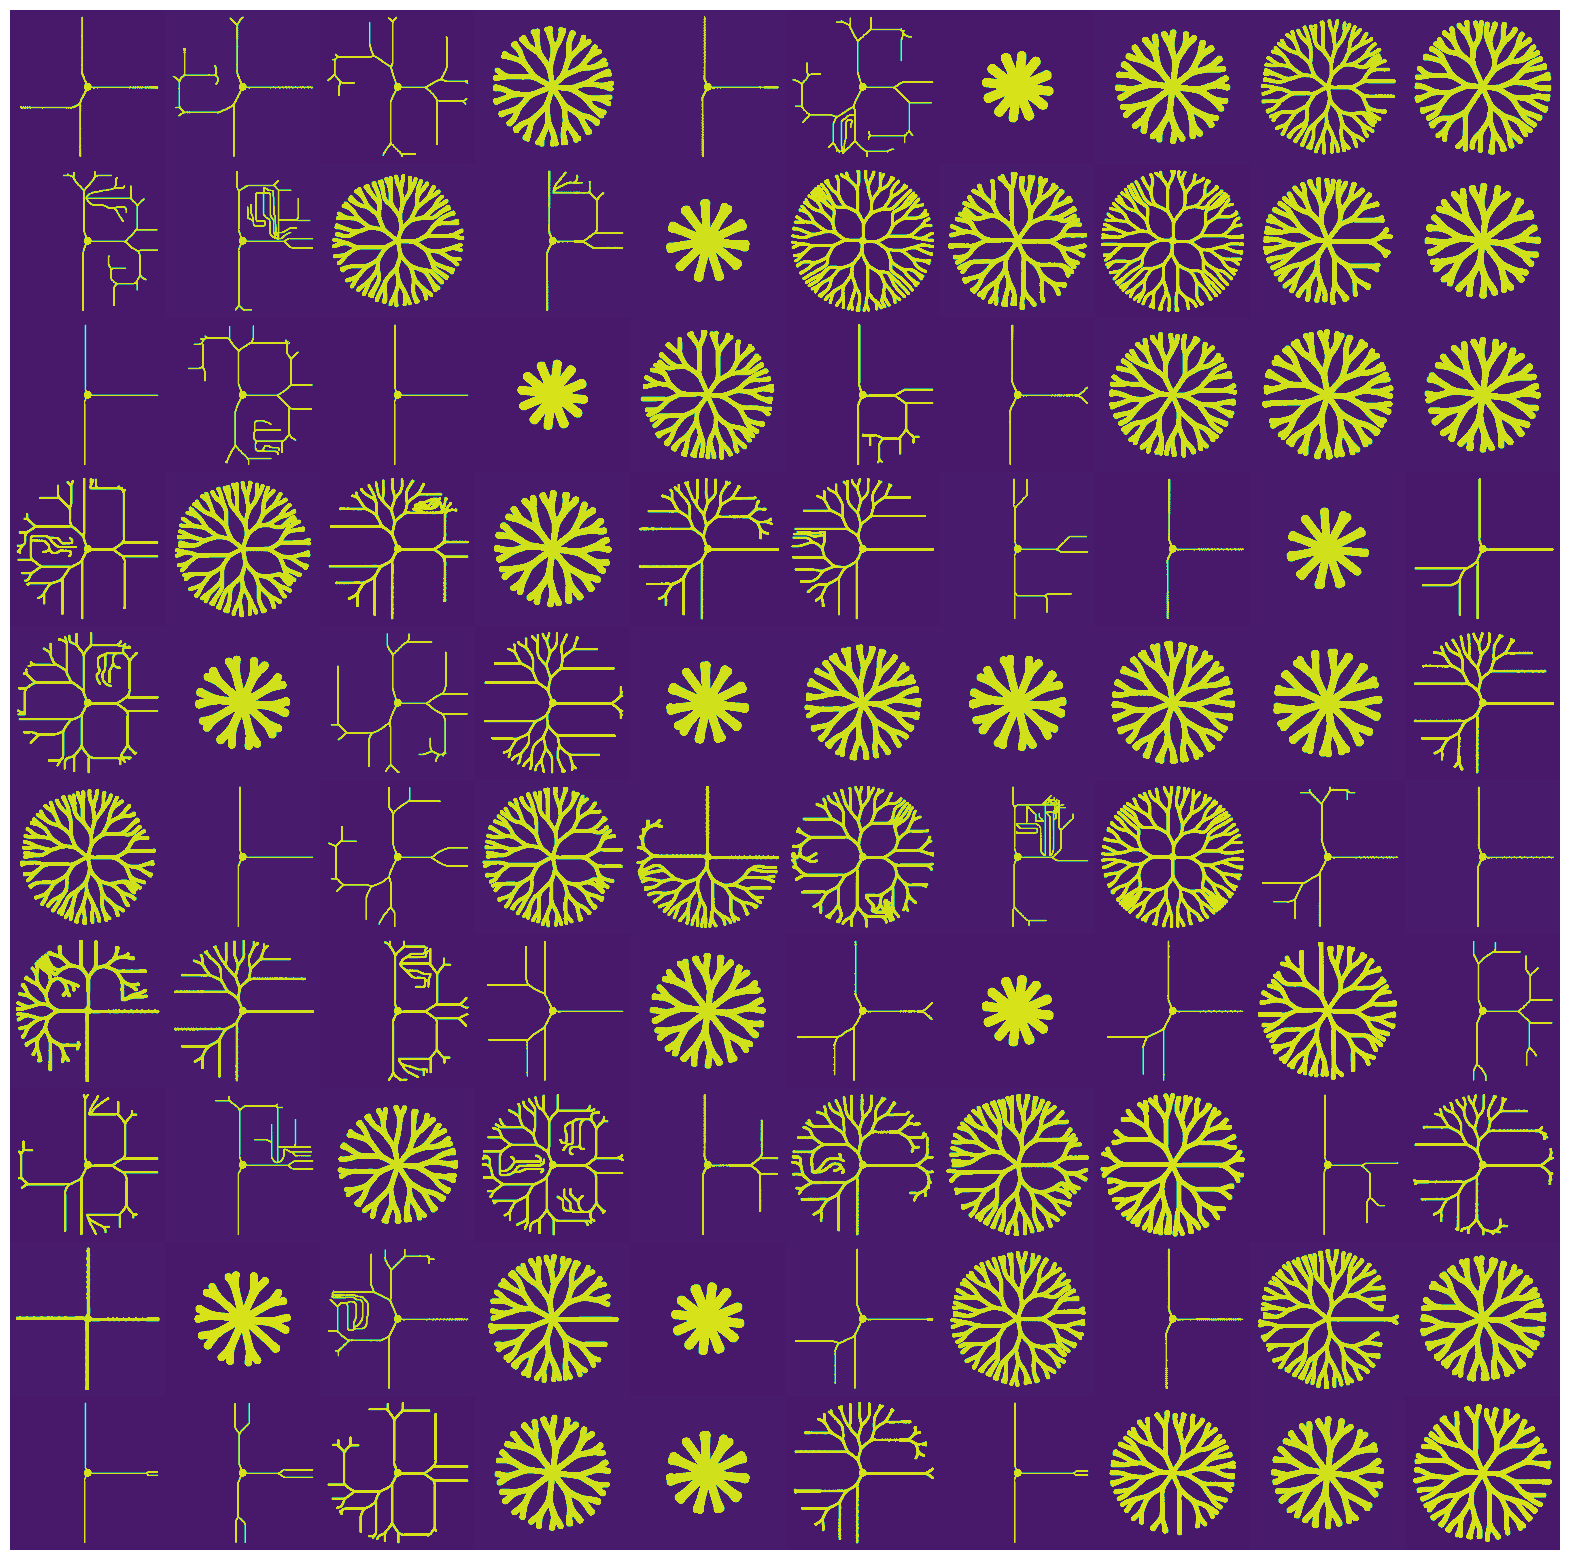

In [726]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Assuming final_states and parameters are defined earlier in your code
final_patterns = final_states[1]
#C_field = compute_potential(final_patterns, decay_kernel)
nutrient = final_states[0]
print(final_patterns.shape)

# Create subplots with no space between them
fig, axs = plt.subplots(
    10, 10, 
    figsize=(20, 20), 
    gridspec_kw={'wspace': 0, 'hspace': 0}  # Remove whitespace between subplots
)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over each axis and plot the contour
for i, ax in tqdm(enumerate(axs), total=len(axs)):
    # Plot the contour with the origin aligned to the lower left
    contour = ax.contourf(final_patterns[i], origin='lower')
    
    # Remove x and y ticks for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Optionally, remove the axis border for an even cleaner appearance
    ax.axis('off')

# Optionally, adjust the layout further if needed
# plt.tight_layout()  # Can be used instead of gridspec_kw adjustments
# fig.subplots_adjust(wspace=0, hspace=0)  # Another way to adjust spacing

# Display the plot
plt.show()


In [727]:
print(jnp.max(nutrient), jnp.min(nutrient))


11.948112 7.8837074e-05


  0%|          | 0/100 [00:00<?, ?it/s]

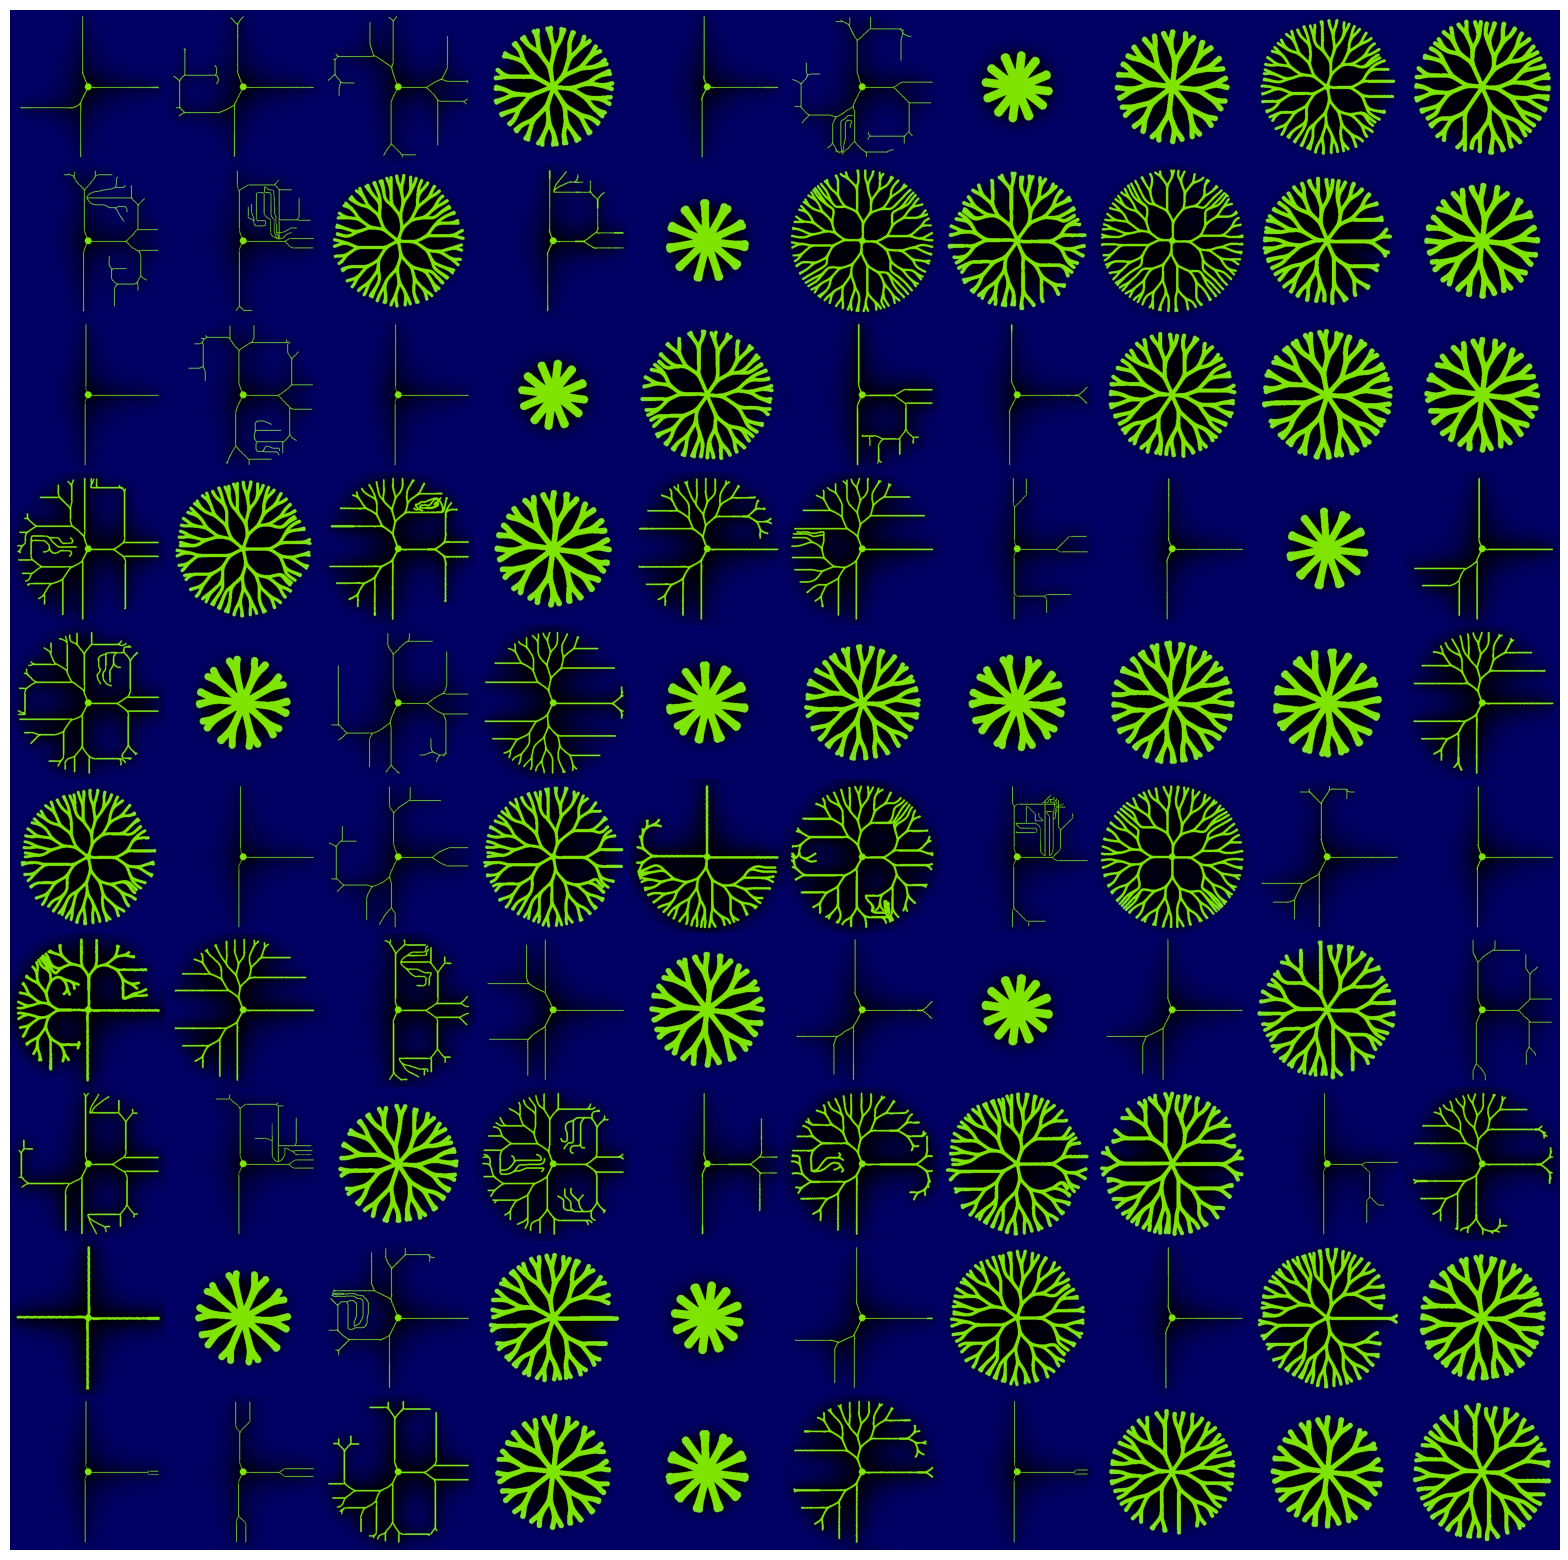

<Figure size 640x480 with 0 Axes>

In [728]:

# Separate channels
cell_density = final_states[1]  # Cell density 1 (Red channel)
nutrient = final_states[0]        # Nutrient profile (Green channel)

# Normalize each channel in each image independently
def normalize_per_image(channel):
    # Normalize each 2D slice to its own max value
    return jnp.clip(channel / (channel.max(axis=(1, 2), keepdims=True)), 0, 1)

# Normalize the channels
cell_density_normalized = normalize_per_image(cell_density)
nutrient_normalized = normalize_per_image(nutrient)
dummy = jnp.zeros(cell_density_normalized.shape)

# Create RGB image: R = Cell density 1, G = Nutrient, B = Cell density 2
#rgb_patterns = jnp.stack(
#    [cell_density_normalized, 0.6 * nutrient_normalized, 0.7 * cell_density_normalized], axis=-1
#)
rgb_patterns = jnp.stack(
    [0.5 * cell_density_normalized, 0.9 * cell_density_normalized, 0.4 * nutrient_normalized], axis=-1
)
# Visualization
from tqdm.notebook import tqdm
# Create subplots with no space between them
fig, axs = plt.subplots(
    10, 10, 
    figsize=(20, 20), 
    gridspec_kw={'wspace': -0.01, 'hspace': -0.01}  # Remove whitespace between subplots
)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over each axis and plot the contour
for i, ax in tqdm(enumerate(axs), total=len(axs)):
    # Plot the contour with the origin aligned to the lower left
    ax.imshow(rgb_patterns[i], origin='lower')  # Display as an RGB image
     
    # Remove x and y ticks for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Optionally, remove the axis border for an even cleaner appearance
    ax.axis('off')

# Optionally, adjust the layout further if needed
# plt.tight_layout()  # Can be used instead of gridspec_kw adjustments
# fig.subplots_adjust(wspace=0, hspace=0)  # Another way to adjust spacing

# Display the plot
plt.show()


plt.tight_layout()
plt.show()
